In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()
#from google.colab import drive

In [19]:
#drive.mount('/content/gdrive', force_remount=True)

In [20]:
#import sys
#sys.path.append('/content/gdrive/My Drive/data_2_categories')

In [7]:
#laod data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
BatchSize = 64
train_datesets = datasets.ImageFolder('./DD2424Pro-part2/dataset/train', data_transforms['train'])
train_loaders = torch.utils.data.DataLoader(train_datesets, batch_size=BatchSize, shuffle=True, num_workers=8)
train_dataset_sizes = len(train_datesets)

val_datesets = datasets.ImageFolder('./DD2424Pro-part2/dataset/val', data_transforms['val'])
val_loaders = torch.utils.data.DataLoader(val_datesets, batch_size=BatchSize, shuffle=True, num_workers=8)
val_dataset_sizes = len(val_datesets)

test_datesets = datasets.ImageFolder('./DD2424Pro-part2/dataset/test', data_transforms['test'])
test_loaders = torch.utils.data.DataLoader(test_datesets, batch_size=BatchSize, shuffle=True, num_workers=8)
test_dataset_sizes = len(test_datesets)

class_name = train_datesets.classes
device = torch.device("cuda:0")


In [8]:
model_tuned = models.resnet50(weights="IMAGENET1K_V1")

num_features = model_tuned.fc.in_features
output_size = 37
inter1_size = 1024
inter2_size = 512
dropout_rate = 0.5
max_iters = 40
model_tuned.fc = nn.Sequential(nn.Linear(num_features, inter1_size),
                               nn.BatchNorm1d(inter1_size),
                               nn.ReLU(inplace=True),
                               nn.Dropout(dropout_rate),
                               nn.Linear(inter1_size, inter2_size),
                               nn.BatchNorm1d(inter2_size),
                               nn.ReLU(inplace=True), 
                               nn.Dropout(dropout_rate),
                               nn.Linear(inter2_size, output_size))
model_tuned = model_tuned.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tuned.parameters(), lr=5e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [23]:
'''## no training
test_accs = []
test_losses = []
    ################### TEST ####################
model_tuned.eval()

running_loss = 0
accuracy = 0

for inputs, labels in test_loaders:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    with torch.set_grad_enabled(False):

      output = model_tuned(inputs)
      _, preds = torch.max(output, 1)
      loss = criterion(output, labels)

    running_loss += loss.item() * inputs.size(0)
    accuracy += torch.sum(preds == labels.data)

test_loss = running_loss / test_dataset_sizes
test_accuracy = accuracy / test_dataset_sizes

test_accs.append(test_accuracy.item())
test_losses.append(test_loss)

print("test loss: {:.2f} \t acc : {:.2f}".format(test_loss,test_accuracy))'''

'## no training\ntest_accs = []\ntest_losses = []\n    ################### TEST ####################\nmodel_tuned.eval()\n\nrunning_loss = 0\naccuracy = 0\n\nfor inputs, labels in test_loaders:\n    inputs = inputs.to(device)\n    labels = labels.to(device)\n\n    optimizer.zero_grad()\n\n    with torch.set_grad_enabled(False):\n\n      output = model_tuned(inputs)\n      _, preds = torch.max(output, 1)\n      loss = criterion(output, labels)\n\n    running_loss += loss.item() * inputs.size(0)\n    accuracy += torch.sum(preds == labels.data)\n\ntest_loss = running_loss / test_dataset_sizes\ntest_accuracy = accuracy / test_dataset_sizes\n\ntest_accs.append(test_accuracy.item())\ntest_losses.append(test_loss)\n\nprint("test loss: {:.2f} \t acc : {:.2f}".format(test_loss,test_accuracy))'

In [9]:
max_iters = 40
train_losses = []
train_accs = []

val_accs = []
val_losses = []

test_accs = []
test_losses = []

best_model_para = copy.deepcopy(model_tuned.state_dict())
best_accuracy = 0

for epoch in range(max_iters):
    running_loss = 0
    running_accuracy = 0

    ################### TRAINING ####################
    model_tuned.train()

    for inputs, labels in train_loaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):

          outputs = model_tuned(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)

    scheduler.step()
    epoch_loss = running_loss/ train_dataset_sizes
    epoch_acc = running_accuracy.double() / train_dataset_sizes
    train_accs.append(epoch_acc.item())
    train_losses.append(epoch_loss)

    if epoch % 1 == 0:
        print("training itr: {:02d} \t loss: {:.2f} \t acc : {:.2f}".format(epoch,epoch_loss,epoch_acc))

    ################### VALIDATION ####################
    model_tuned.eval()

    running_loss = 0
    running_accuracy = 0

    for inputs, labels in val_loaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(False):

          outputs = model_tuned(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)

    epoch_loss = running_loss/ val_dataset_sizes
    epoch_acc = running_accuracy.double() / val_dataset_sizes

    val_accs.append(epoch_acc.item())
    val_losses.append(epoch_loss)

    if epoch_acc > best_accuracy:
        best_accuracy = epoch_acc
        best_model_para = copy.deepcopy(model_tuned.state_dict())

    if epoch % 1 == 0:
        print("validation itr: {:02d} \t loss: {:.2f} \t acc : {:.2f}".format(epoch,epoch_loss,epoch_acc))

model_tuned.load_state_dict(best_model_para)

    ################### TEST ####################
model_tuned.eval()

running_loss = 0
accuracy = 0

for inputs, labels in test_loaders:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    with torch.set_grad_enabled(False):

      output = model_tuned(inputs)
      _, preds = torch.max(output, 1)
      loss = criterion(output, labels)

    running_loss += loss.item() * inputs.size(0)
    accuracy += torch.sum(preds == labels.data)

test_loss = running_loss / test_dataset_sizes
test_accuracy = accuracy / test_dataset_sizes

test_accs.append(test_accuracy.item())
test_losses.append(test_loss)

print("test loss: {:.2f} \t acc : {:.2f}".format(test_loss,test_accuracy))

training itr: 00 	 loss: 2.69 	 acc : 0.38
validation itr: 00 	 loss: 1.20 	 acc : 0.88
training itr: 01 	 loss: 1.49 	 acc : 0.75
validation itr: 01 	 loss: 0.68 	 acc : 0.92
training itr: 02 	 loss: 1.05 	 acc : 0.82
validation itr: 02 	 loss: 0.49 	 acc : 0.94
training itr: 03 	 loss: 0.85 	 acc : 0.84
validation itr: 03 	 loss: 0.37 	 acc : 0.94
training itr: 04 	 loss: 0.71 	 acc : 0.87
validation itr: 04 	 loss: 0.30 	 acc : 0.94
training itr: 05 	 loss: 0.63 	 acc : 0.88
validation itr: 05 	 loss: 0.27 	 acc : 0.95
training itr: 06 	 loss: 0.57 	 acc : 0.89
validation itr: 06 	 loss: 0.26 	 acc : 0.95
training itr: 07 	 loss: 0.51 	 acc : 0.90
validation itr: 07 	 loss: 0.24 	 acc : 0.95
training itr: 08 	 loss: 0.50 	 acc : 0.90
validation itr: 08 	 loss: 0.24 	 acc : 0.95
training itr: 09 	 loss: 0.47 	 acc : 0.90
validation itr: 09 	 loss: 0.22 	 acc : 0.95
training itr: 10 	 loss: 0.44 	 acc : 0.91
validation itr: 10 	 loss: 0.21 	 acc : 0.95
training itr: 11 	 loss: 0.41 	 

In [47]:
model_tuned.load_state_dict(best_model_para)

    ################### TEST ####################
model_tuned.eval()

running_loss = 0
accuracy = 0

for inputs, labels in test_loaders:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    with torch.set_grad_enabled(False):

      output = model_tuned(inputs)
      _, preds = torch.max(output, 1)
      loss = criterion(output, labels)

    running_loss += loss.item() * inputs.size(0)
    accuracy += torch.sum(preds == labels.data)

test_loss = running_loss / test_dataset_sizes
test_accuracy = accuracy / test_dataset_sizes

test_accs.append(test_accuracy.item())
test_losses.append(test_loss)

print("test loss: {:.2f} \t acc : {:.2f}".format(test_loss,test_accuracy))

test loss: 0.23 	 acc : 0.93


train_losses: 
 [2.688328801433153, 1.4902839453203771, 1.0491397120836439, 0.8510921591488041, 0.7121588922892996, 0.6259986263140171, 0.5725422522308102, 0.5148828749682492, 0.4983867251955993, 0.46765688112421916, 0.43528056036384183, 0.414388001287804, 0.4069742191833576, 0.4020823303664828, 0.39457133972451197, 0.3702834863719881, 0.362590563223515, 0.3606348326753851, 0.33800825492780706, 0.33311519757408736, 0.3226685872372047, 0.3287898961855106, 0.32131666113310603, 0.3511539569033824, 0.3281729677022195, 0.3197806989003408, 0.30324063507144244, 0.3179946784952861, 0.3277659315128983, 0.3058420441820007, 0.3026486556726376, 0.3090064568705828, 0.31244667467919784, 0.3136114110019165, 0.31921873266440626, 0.3159143003676164, 0.31518138623569514, 0.30970426382063343, 0.32649514602305624, 0.31699669752947046] 
 train_accs 
 [0.3776102088167054, 0.7463263727764888, 0.8186388244392885, 0.8383604021655067, 0.8654292343387472, 0.8816705336426914, 0.8892111368909513, 0.902358855375096

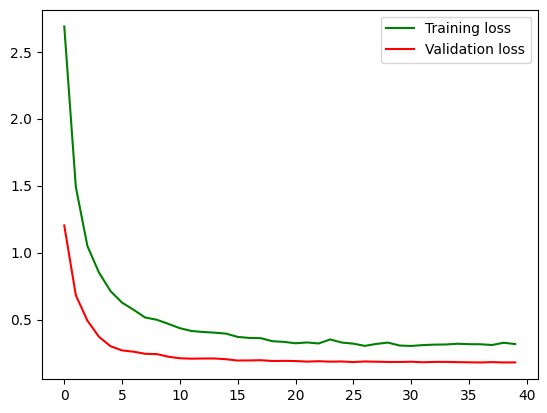

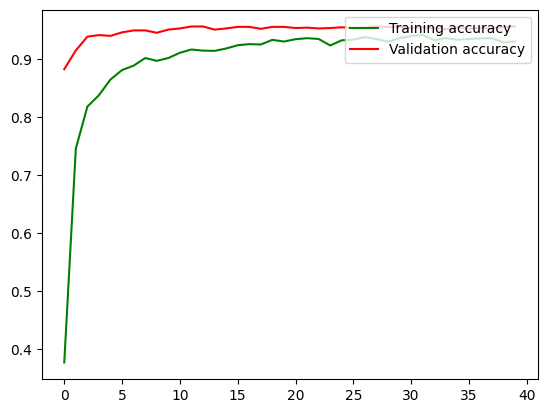

In [10]:
#batch size 64
from matplotlib import pyplot as plt
fig = plt.figure()

plt.plot(train_losses, 'g', label="Training loss")
plt.plot(val_losses, 'r', label="Validation loss")
#plt.plot(test_losses, 'b', label="Test cost")
plt.legend(loc="upper right")

fig2 = plt.figure()
plt.plot(train_accs, 'g', label="Training accuracy")
plt.plot(val_accs, 'r', label="Validation accuracy")
#plt.plot(test_accs, 'b', label="Test loss")
plt.legend(loc="upper right")

print(f"train_losses: \n {train_losses} \n train_accs \n {train_accs} \n val_accs \n {val_accs} \n val_losses \n {val_losses} \n test_accs \n {test_accs} \n test_losses \n {test_losses}")

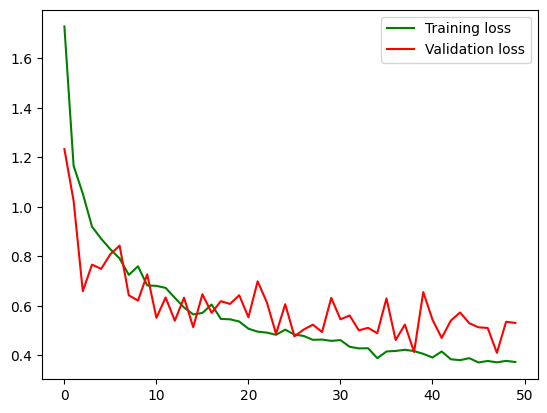

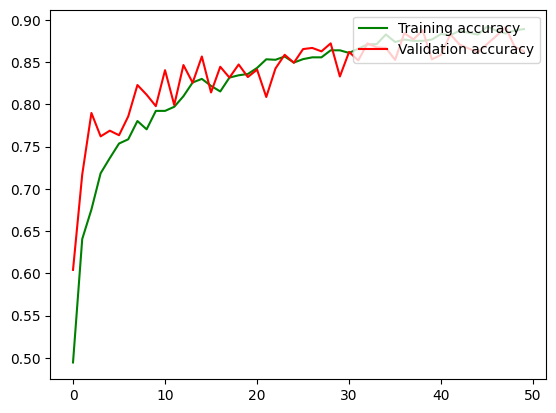

In [24]:
#batch size 32
from matplotlib import pyplot as plt
fig = plt.figure()

plt.plot(train_losses, 'g', label="Training loss")
plt.plot(val_losses, 'r', label="Validation loss")
#plt.plot(test_losses, 'b', label="Test cost")
plt.legend(loc="upper right")

fig2 = plt.figure()
plt.plot(train_accs, 'g', label="Training accuracy")
plt.plot(val_accs, 'r', label="Validation accuracy")
#plt.plot(test_accs, 'b', label="Test loss")
plt.legend(loc="upper right")

In [25]:
#batch size 32
print(f"train_losses: \n {train_losses} \n train_accs \n {train_accs} \n val_accs \n {val_accs} \n val_losses \n {val_losses} \n test_accs \n {test_accs} \n test_losses \n {test_losses}")

train_losses: 
 [1.7284754476893898, 1.1659689965583702, 1.0533720795166004, 0.9198579899765038, 0.8707959622905315, 0.8282679738873027, 0.7913538184815013, 0.7249809625253877, 0.7596716783070694, 0.6822697795921763, 0.6804892577962736, 0.6725739069622981, 0.6322218882004973, 0.5931886758623617, 0.5652876345344228, 0.5711852621405233, 0.6053170411050182, 0.5468978282101654, 0.5455404012957379, 0.5365178937701781, 0.5075468724767828, 0.4955561408817722, 0.4916843707858364, 0.48291944026117256, 0.5035138776020218, 0.48382044702837473, 0.4782447912208073, 0.4625487285626552, 0.46368763254118445, 0.45828375607521515, 0.46153985407586623, 0.4345373381087693, 0.4279298140665218, 0.42857555926353175, 0.3884656752552621, 0.4154991871934479, 0.4175974351439657, 0.4224376835776039, 0.41714726864415735, 0.405875859777778, 0.3911638635470714, 0.41545869443459005, 0.3839576605301169, 0.3804379748634285, 0.3884555509822459, 0.371046807377816, 0.377188954073057, 0.3715219236535797, 0.3775189465685399